In [17]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import sys
sys.path.append('/home/xalanaseon/scapy-cip-enip')
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/xalanaseon/scapy-cip-enip')
from cip import CIP, CIP_Path
import cip
import numpy as np

plc_cube = []
hmi_cube = []
#seq = [[],[]]

### Convert ip address string to integer
def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

def packet_analysis(pkt):
    if IP in pkt and TCP in pkt:
        if len(pkt[TCP].payload) > 6:
        #print(pkt[CIP].SERVICE_CODES[pkt[CIP].service])
        #pkt.show()
            if(pkt[TCP].dport == 44818):
                d_time = float(str(pkt.time))
                s_ip = ip2long(pkt[IP].src)
                d_ip = ip2long(pkt[IP].dst)
                #seq[0].append(pkt[TCP].seq)
                hmi_cube.append([s_ip,d_ip,d_time,-1])
            if(pkt[TCP].sport == 44818):
                d_time = float(str(pkt.time))
                s_ip = ip2long(pkt[IP].src)
                d_ip = ip2long(pkt[IP].dst)
                #seq.append(pkt[TCP].seq)
                plc_cube.append([s_ip,d_ip,d_time,-1])


In [18]:
try:
    sniff(offline='DataSet/Dec2019_00000_20191206100500.pcap', prn=packet_analysis, store=0, count=1000000, filter="host 192.168.1.10 and host 192.168.1.20")
    #sniff(offline='DataSet/Dex2019_0002_attack3.pcap', prn=packet_analysis, store=0, count=100000, filter="src host 192.168.1.10 and dst host 192.168.1.20")
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [19]:
print(hmi_cube.shape)
print(plc_cube.shape)
print(plc_cube[2][0])

(220260, 4)
(220264, 4)
3232235796.0


In [20]:
#print(CIP.SERVICE_CODES)
#hmi_data = hmi_cube[hmi_cube[:,3]==[76]]
hmi_data = hmi_cube[hmi_cube[:,0]==[ip2long('192.168.1.10')]]
hmi_data = hmi_data[hmi_data[:,1]==[ip2long('192.168.1.20')]]
hmi_data = hmi_data[:,2]
print(hmi_data.shape)
print("Sliding Windows Timespan :",max(hmi_data)-min(hmi_data))

(220260,)
Sliding Windows Timespan : 899.0120739936829


In [21]:
hmi_diff = np.diff(hmi_data)
print(hmi_diff.shape)

(220259,)


1.0000000000000004
[0.35945331 0.16192251 0.0706503  0.03034744]
[0.3497788  0.03371676 0.01522641 0.0066039 ]
(array([ 12.66692733, 127.85783847, 130.62189015, 130.8205646 ]), array([0.3497788 , 0.03371676, 0.01522641, 0.0066039 ]), array([  0.76632085, 184.40524245, 430.48762145, 673.38621871]), array([ 13.43324818, 312.26308093, 561.1095116 , 804.20678331]))
Xplot_peak [[0.00014014]
 [0.00500501]
 [0.00996997]
 [0.01471471]]
normal peaks [[1.40140140e-04 3.59453315e-01]
 [5.00500501e-03 1.61922507e-01]
 [9.96996997e-03 7.06502955e-02]
 [1.47147147e-02 3.03474395e-02]]
normal bounds [[1.53264169e-05 2.68664964e-04 3.49778799e-01]
 [3.68810485e-03 6.24526162e-03 3.37167580e-02]
 [8.60975243e-03 1.12221902e-02 1.52264112e-02]
 [1.34677244e-02 1.60841357e-02 6.60390255e-03]]
Minima: [0.00256256 0.00738739 0.01249249 0.017998  ]
Maxima: [0.00014014 0.00500501 0.00996997 0.01471471]


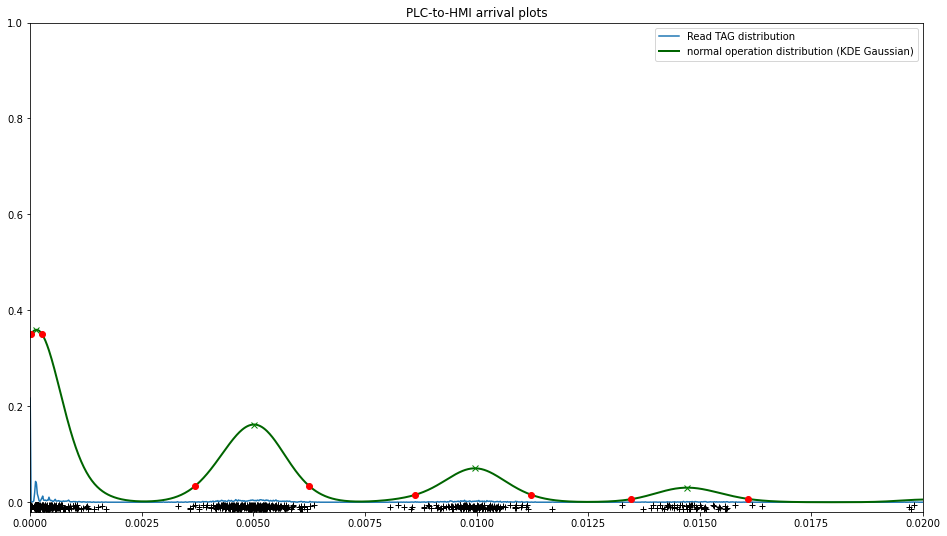

In [22]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, chirp, find_peaks, peak_widths

maxrange = 0.02
N = 1000
np.random.seed(1)
X = hmi_diff[:1000].reshape(-1,1)
X_plot = np.linspace(-0.0, maxrange, N)[:, np.newaxis]
hist, bin_edges = np.histogram(hmi_diff[:3000], bins=N, range=(0.0,maxrange), density=True)
bin_edges = bin_edges[:-1]
true_dens = hist[:]*maxrange*(1/N)
print(np.sum(true_dens))

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(X_plot[:, 0], true_dens,label='Read TAG distribution')

kde = KernelDensity(kernel='gaussian', bandwidth=0.0005).fit(X)
log_dens = kde.score_samples(X_plot)
#print(kde.get_params())
dens = np.exp(log_dens)/1000

peaks, _ = find_peaks(dens)

valleys = peak_widths(dens, peaks, rel_height=0.8)

print(dens[peaks])
print(valleys[1])
print(valleys)
print("Xplot_peak",X_plot[peaks])
ax.plot(X_plot[:, 0], dens, color='darkgreen', lw=2,
        linestyle='-', label='normal operation distribution (KDE Gaussian)')
ax.plot(X_plot[peaks],dens[peaks], "gx")
#ax.plot(X_plot[valleys],dens[valleys], "go")
ax.plot(valleys[2]*maxrange*(1/N),valleys[1], "ro")
ax.plot(valleys[3]*maxrange*(1/N),valleys[1], "ro")

#stack position and values
nppeaks = np.hstack((X_plot[peaks],dens[peaks].reshape(-1,1)))
npbounds = np.stack((valleys[2]*maxrange*(1/N),valleys[3]*maxrange*(1/N),valleys[1]), axis=-1)
print("normal peaks",nppeaks)
print("normal bounds",npbounds)
np.save("np_peaks_CRITIS.npy",nppeaks)
np.save("np_bounds_CRITIS.npy",npbounds)

ax.title.set_text("PLC-to-HMI arrival plots")
ax.legend(loc='upper right')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-0.0, maxrange)
ax.set_ylim(-0.02, 1.0)

s = X_plot[:, 0]
e = np.exp(log_dens)/1000
a = X
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])